# Malaria Predictive Modelling

In [83]:
# Insert image

## Business Understanding

### Executive Summary


Kenya’s health system continues to carry a heavy burden of infectious diseases; malaria remains a leading public‑health challenge, with 10 counties accounting for ~95% of the national burden. Turkana is among the highest‑burden areas, and Turkana West (Kakuma Refugee Camp) alone has managed >65,000 malaria cases annually over the past five years, with peaks occurring at different, increasingly unpredictable times of the year. Climate variability has disrupted the reliability of rainy seasons in arid and semi‑arid lands (ASAL), making reactive, delayed, and resource‑intensive responses the norm—resulting in lost livelihoods and schooling, stock‑outs, HCW burnout, and excess morbidity and mortality, especially among pregnant women and children.This capstone proposes a climate‑informed malaria early warning and response (EWR) platform that combines recent weather conditions (rainfall, temperature, humidity) with historical malaria trends to predict timing, magnitude, and risk of outbreaks up to four weeks ahead. Evidence from recent studies shows that climate‑driven machine learning (ML), including Transformer architectures, materially improves outbreak detection performance and operational decision‑making—providing the lead time needed to pre‑position commodities, optimize CHW outreach, and protect vulnerable groups.


### Context and Need

Malaria transmission depends on vector–parasite ecology. Ambient temperatures above ~18 °C, standing water, and bushy surroundings are favorable for mosquito breeding; in ASAL counties, these conditions surge after rains, often triggering outbreaks. In Kakuma, the shifting onset and intensity of rains have eroded seasonal predictability, undermining preparedness and forcing last‑minute responses that overrun staff and supplies.


### Opportunity

Move from reactive to proactive malaria control by institutionalizing a 4‑week forecast that translates climate signals and local case trends into simple, actionable risk alerts for MoH/County planners, health‑facility managers, CHWs, and humanitarian partners. This approach aligns with the broader healthcare trend in which ML‑driven predictive analytics improves resource allocation, timeliness, and patient outcomes when embedded in routine workflows.

### Problem statement:


How can high-resolution temporal weather data (rainfall, temperature, windspeed, humidity) combined with historical malaria case trends improve the accuracy of short-term malaria outbreak forecasts in endemic regions?

### Stakeholders:

* **Ministry of Health / County DoH** – Earlier, risk‑based deployment of nets, sprays, RDTs/ACTs; budget protection via planned procurement and surge staffing; stronger surveillance as a core intervention. 
* **Health managers (facility/NGO)** – Workload smoothing (rosters, triage), stockout avoidance, and targeted outreach calendars pegged to forecasted peaks. 
* **Community Health Workers** – Actionable weekly briefs (hotspot villages, home visits, net‑hang‑up campaigns) timed to risk tiers for maximal impact. 
* **Humanitarian partners/donors** – Measurable, data‑driven preparedness, enabling cost‑effective targeting and transparent reporting on lead‑time and outcomes. 


### Success Metrics:

* **Lead time**: Consistently deliver 4‑week forecasts at facility/catchment level. 
* **Forecast quality (regression)**: RMSE, MAE, R²; Time‑series: MASE; Classification: Precision/Recall, F1, ROC‑AUC for outbreak/no‑outbreak alerts. 
* **Operational uptake**: % of alerts actioned within 7 days; stockout rate during peaks; CHW coverage in high‑risk zones. 


## Data Understanding

### Step 1: Data Acquisition

* Malaria case data: Extract from facility-level data, case counts and malaria positivity (e.g., Kakuma Refugee Camp).

* Weather data: Pull Open-Meteo APIs (variables should include rainfall, temperature, humidity, wind speed).


In [84]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
malaria_df = pd.read_csv("Data/Malaria_dataset.csv")
malaria_df.head()

,Date,Positive_Count_cases
0,5/1/2021,2
1,5/2/2021,9
2,5/3/2021,2
3,5/4/2021,9
4,5/5/2021,7


In [86]:
malaria_df.shape

(1308, 2)

In [87]:
weather_df = pd.read_csv("Data/Weather_dataset.csv")
weather_df.head()

,Date,temperature_2m_mean (°C),rain_sum (mm),wind_speed_10m_max (km/h),apparent_temperature_mean (°C),relative_humidity_2m_mean (%),relative_humidity_2m_max (%),relative_humidity_2m_min (%),surface_pressure_mean (hPa),surface_pressure_max (hPa),...,temperature_2m_min (°C),temperature_2m_max (°C),weather_code (wmo code),sunrise (iso8601),sunset (iso8601),daylight_duration (s),sunshine_duration (s),precipitation_sum (mm),precipitation_hours (h),snowfall_sum (cm)
0,5/1/2021,28.7,0.2,18.0,30.5,56,87,33,943.1,946.0,...,22.7,34.2,51,2021-05-01T06:30,2021-05-01T18:45,44097.46,40347.95,0.2,2,0
1,5/2/2021,28.8,1.8,28.3,30.3,51,71,30,942.8,945.5,...,22.9,35.1,53,2021-05-02T06:30,2021-05-02T18:45,44108.07,40052.62,1.8,5,0
2,5/3/2021,26.4,10.8,16.5,29.2,67,83,41,943.9,946.6,...,22.5,32.4,61,2021-05-03T06:29,2021-05-03T18:45,44118.54,36528.70,10.8,12,0
3,5/4/2021,28.3,0.7,22.6,30.2,60,86,32,942.9,945.9,...,23.4,34.8,51,2021-05-04T06:29,2021-05-04T18:45,44128.87,40054.13,0.7,5,0
4,5/5/2021,28.8,2.7,16.4,30.8,57,84,36,943.4,946.3,...,24.2,33.6,55,2021-05-05T06:29,2021-05-05T18:45,44139.04,40251.84,2.7,10,0


In [88]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 55 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Date                                    1309 non-null   object 
 1   temperature_2m_mean (°C)                1309 non-null   float64
 2   rain_sum (mm)                           1309 non-null   float64
 3   wind_speed_10m_max (km/h)               1309 non-null   float64
 4   apparent_temperature_mean (°C)          1309 non-null   float64
 5   relative_humidity_2m_mean (%)           1309 non-null   int64  
 6   relative_humidity_2m_max (%)            1309 non-null   int64  
 7   relative_humidity_2m_min (%)            1309 non-null   int64  
 8   surface_pressure_mean (hPa)             1309 non-null   float64
 9   surface_pressure_max (hPa)              1309 non-null   float64
 10  surface_pressure_min (hPa)              1309 non-null   floa

### Step 2: Data Cleaning & Preprocessing

* Align datasets by time ( daily granularity).

* Handle missing values:
    * Weather: interpolation.
    * Case data: imputation or zero-fill for non-reporting weeks.

* Feature engineering:
    * Lag features (e.g., rainfall 2–4 weeks prior).
    * Rolling averages for smoothing.
Normalize or scale features for ML models.


In [89]:
weather_df_truncated = weather_df[["Date","apparent_temperature_mean (°C)","rain_sum (mm)","relative_humidity_2m_mean (%)","wind_speed_10m_mean (km/h)"]]
weather_df_truncated

,Date,apparent_temperature_mean (°C),rain_sum (mm),relative_humidity_2m_mean (%),wind_speed_10m_mean (km/h)
0,5/1/2021,30.5,0.2,56,10.0
1,5/2/2021,30.3,1.8,51,8.7
2,5/3/2021,29.2,10.8,67,7.8
3,5/4/2021,30.2,0.7,60,12.5
4,5/5/2021,30.8,2.7,57,9.8
...,...,...,...,...,...
1304,11/25/2024,27.7,3.0,66,7.8
1305,11/26/2024,28.4,0.0,67,7.3
1306,11/27/2024,26.6,10.1,77,7.1
1307,11/28/2024,25.8,8.4,81,4.8


In [90]:
weather_df_renamed = weather_df_truncated.rename(columns={
    'Date': 'Date',
    'apparent_temperature_mean (°C)': 'Temperature',
    'rain_sum (mm)': 'Rainfall',
    'relative_humidity_2m_mean (%)': 'Humidity',
    'wind_speed_10m_mean (km/h)': 'WindSpeed'
})

In [91]:
weather_df_renamed.head()

,Date,Temperature,Rainfall,Humidity,WindSpeed
0,5/1/2021,30.5,0.2,56,10.0
1,5/2/2021,30.3,1.8,51,8.7
2,5/3/2021,29.2,10.8,67,7.8
3,5/4/2021,30.2,0.7,60,12.5
4,5/5/2021,30.8,2.7,57,9.8


In [92]:
weather_df_renamed.shape


(1309, 5)

In [93]:
merged_df = pd.merge(
    malaria_df,
    weather_df_renamed,
    on='Date',
    how='inner'   # keep only matching dates
)

In [94]:
merged_df.head()

,Date,Positive_Count_cases,Temperature,Rainfall,Humidity,WindSpeed
0,5/1/2021,2,30.5,0.2,56,10.0
1,5/2/2021,9,30.3,1.8,51,8.7
2,5/3/2021,2,29.2,10.8,67,7.8
3,5/4/2021,9,30.2,0.7,60,12.5
4,5/5/2021,7,30.8,2.7,57,9.8


In [95]:
merged_df.isna().sum()

Date                    0
Positive_Count_cases    0
Temperature             0
Rainfall                0
Humidity                0
WindSpeed               0
dtype: int64

In [96]:
merged_df.duplicated().sum()

np.int64(0)

In [97]:
merged_df.dtypes

Date                     object
Positive_Count_cases      int64
Temperature             float64
Rainfall                float64
Humidity                  int64
WindSpeed               float64
dtype: object

In [98]:
#merged_df.to_csv("Data/Modeling_dataset.csv",index = False)

In [99]:
data = merged_df
data.head()

,Date,Positive_Count_cases,Temperature,Rainfall,Humidity,WindSpeed
0,5/1/2021,2,30.5,0.2,56,10.0
1,5/2/2021,9,30.3,1.8,51,8.7
2,5/3/2021,2,29.2,10.8,67,7.8
3,5/4/2021,9,30.2,0.7,60,12.5
4,5/5/2021,7,30.8,2.7,57,9.8


#### Summary Statistics

In [100]:
data.describe()

,Positive_Count_cases,Temperature,Rainfall,Humidity,WindSpeed
count,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000
mean,173.110092,29.312003,1.389067,45.928899,13.328211
std,199.896886,1.481206,4.244838,14.766025,4.309257
min,0.000000,23.500000,0.000000,19.000000,4.000000
25%,29.000000,28.300000,0.000000,36.000000,10.100000
50%,94.000000,29.300000,0.000000,41.000000,12.900000
75%,248.250000,30.300000,0.400000,54.000000,16.025000
max,1226.000000,33.300000,50.200000,87.000000,28.200000


#### Data Preprocessing

In [101]:
# Convert Date to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

In [102]:
# Ensure numerical columns
numeric_cols = ['Temperature', 'Rainfall', 'Humidity', 'WindSpeed', 'Positive_Count_cases']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

#### Exploratory Data Analysis(EDA)

### Step 3: Exploratory Data Analysis (EDA)

* Visualize trends: Time-series plots of cases vs. weather.
* Correlation analysis: Identify the strongest predictors.
* Seasonality decomposition: Detect periodic patterns.


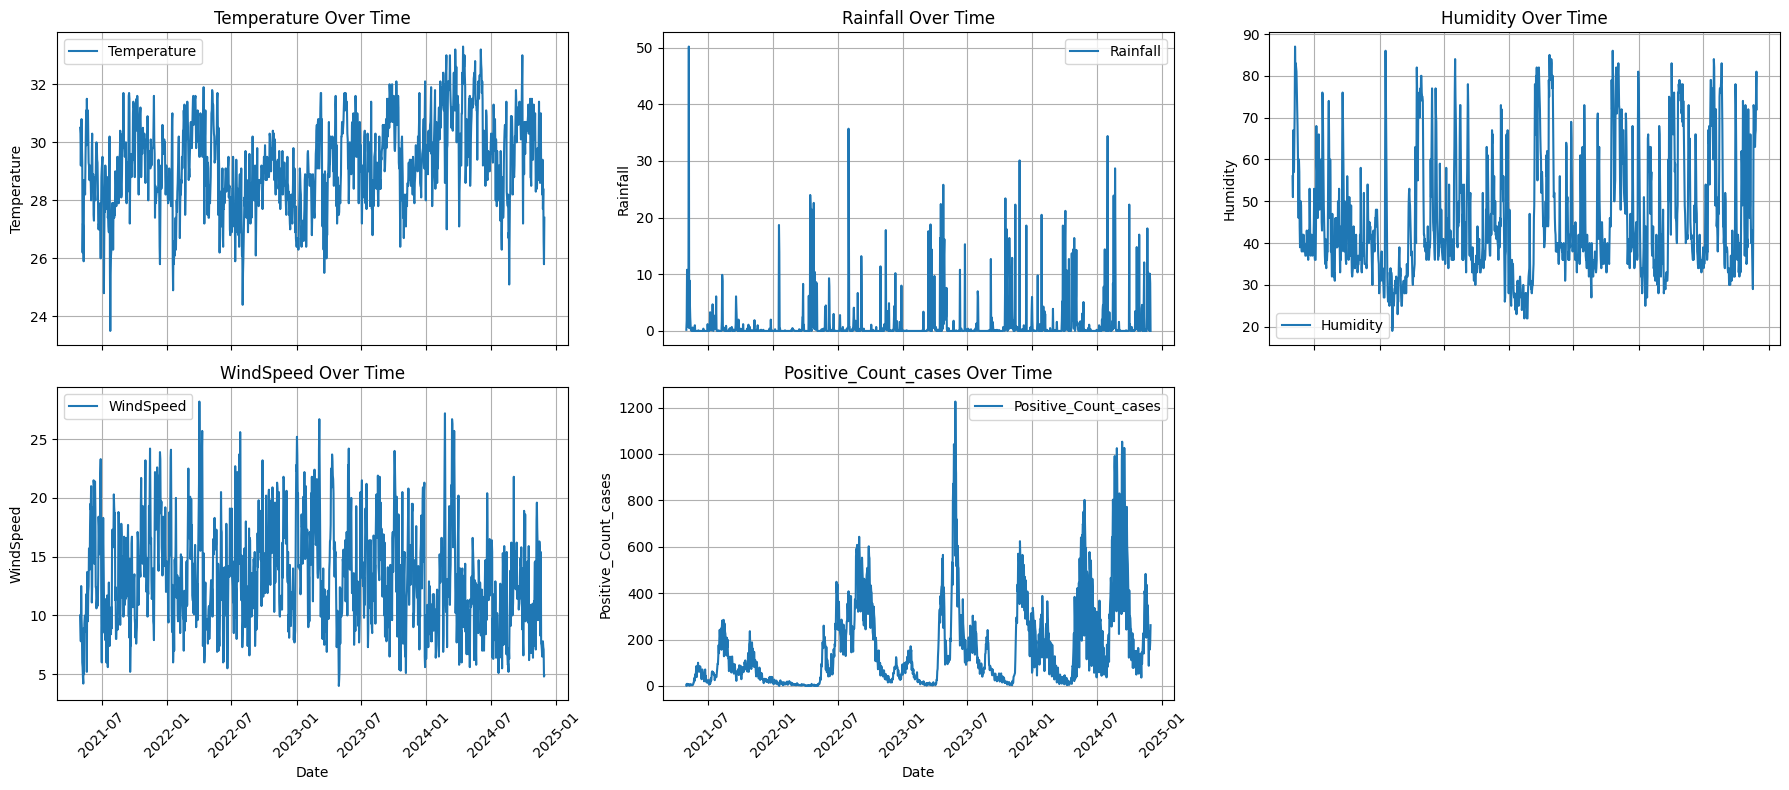

In [103]:
# Create a 2x3 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8), sharex=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each numerical feature
for i, feature in enumerate(numeric_cols):
    axes[i].plot(data['Date'], data[feature], label=feature)
    axes[i].set_title(f'{feature} Over Time')
    axes[i].set_ylabel(feature)
    axes[i].grid(True)  # Add grid to each subplot
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplot (if any)
for i in range(len(numeric_cols), len(axes)):
    axes[i].axis('off')  # Hide unused subplot

# Set x-axis label for the bottom row
for ax in axes[3:]:  # Bottom row (indices 3, 4, 5)
    ax.set_xlabel('Date')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

+ **Temperature:** Displays temperature trends (~23.5–33.3°C), showing minor seasonal fluctuations.
+ **Rainfall:** Shows rainfall patterns (0–50.2 mm), with most days having low or no rainfall and occasional spikes.
+ **Humidity:** Displays humidity trends (~19–87%), with noticeable variations tied to rainfall.
+ **WindSpeed:** Shows wind speed trends (~4.2–28.2 km/h), with moderate variability.

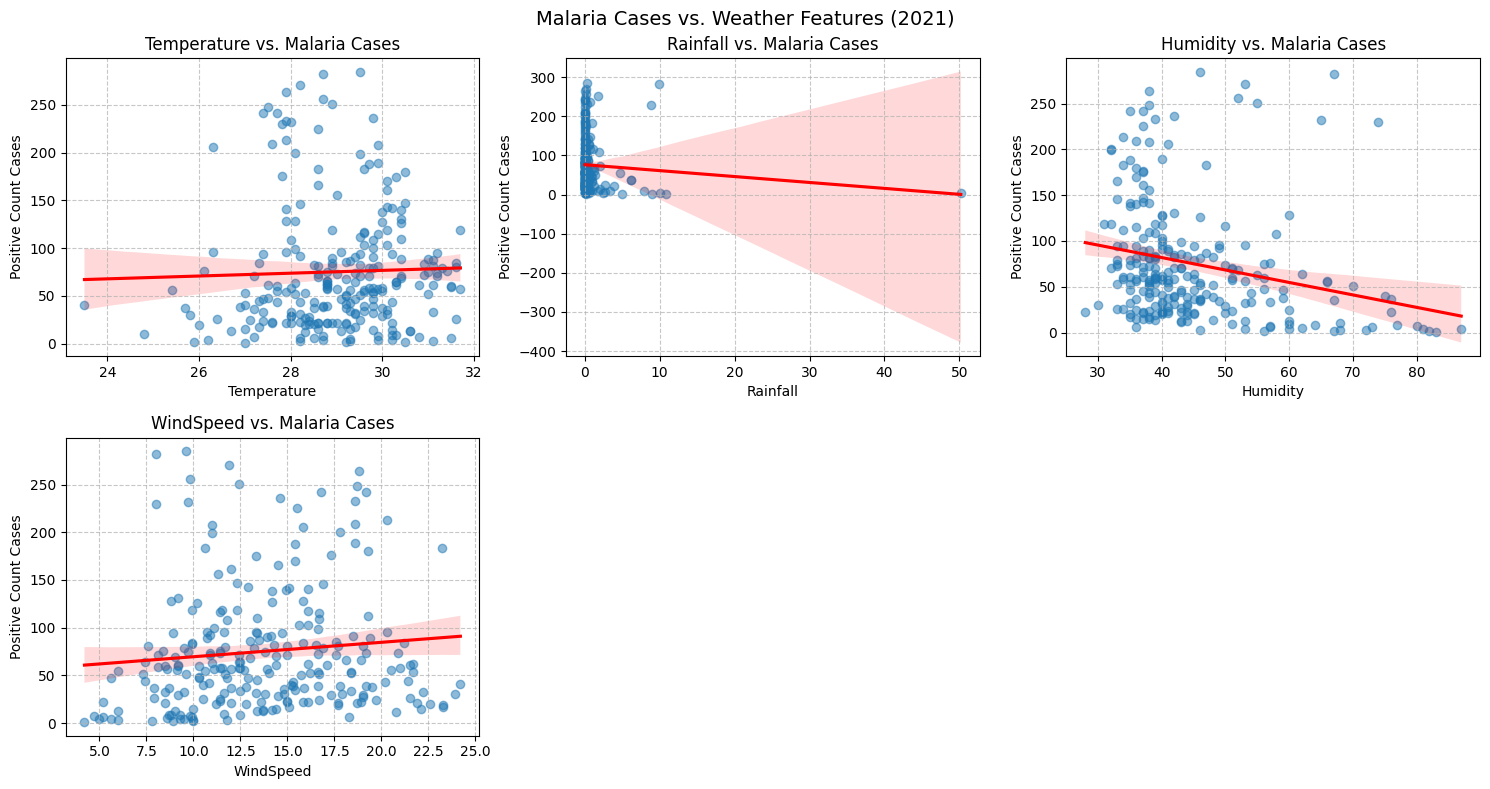


Correlations for 2021:
  Temperature: 0.032
  Rainfall: -0.084
  Humidity: -0.241
  WindSpeed: 0.102


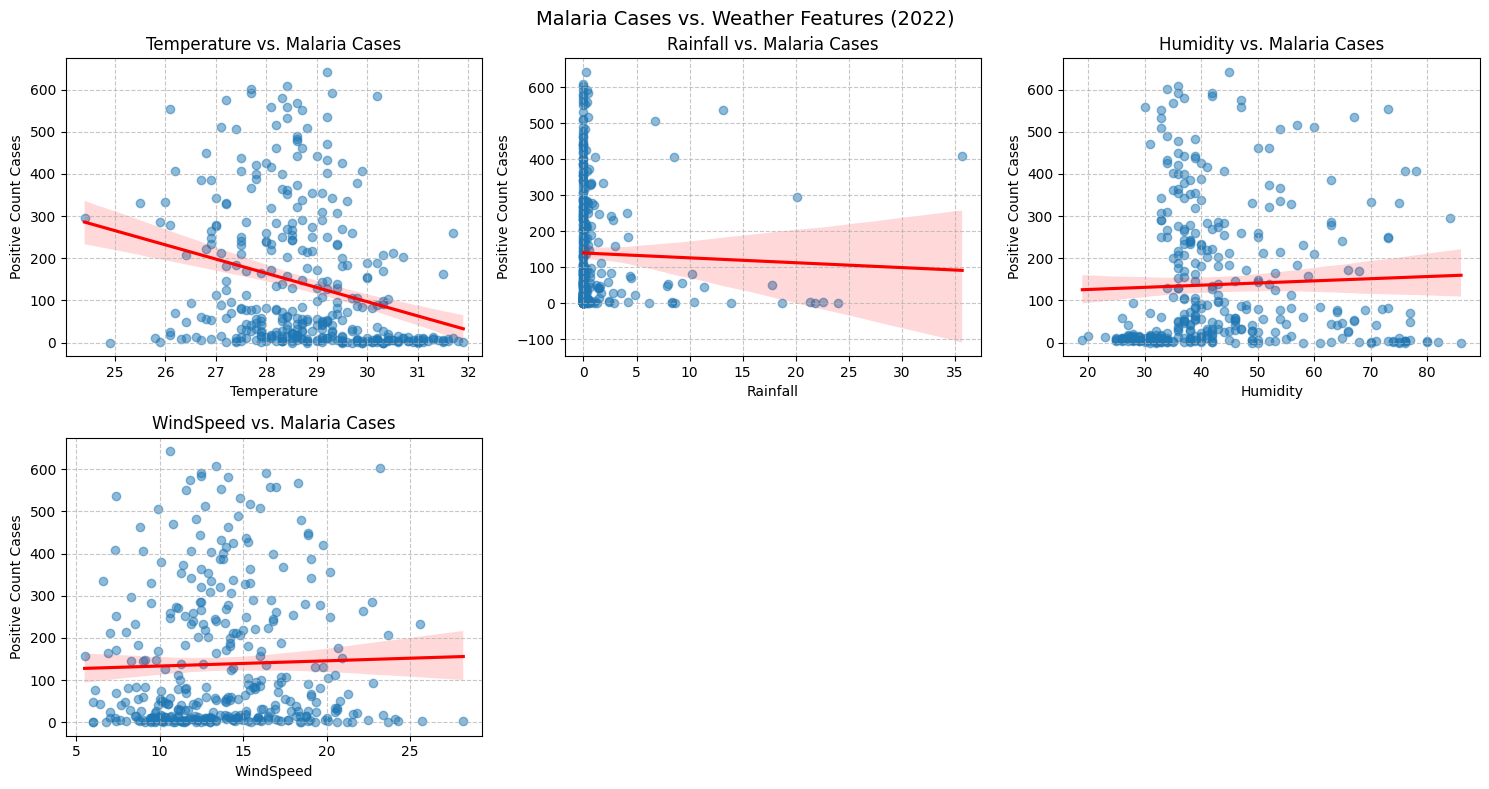


Correlations for 2022:
  Temperature: -0.274
  Rainfall: -0.032
  Humidity: 0.043
  WindSpeed: 0.031


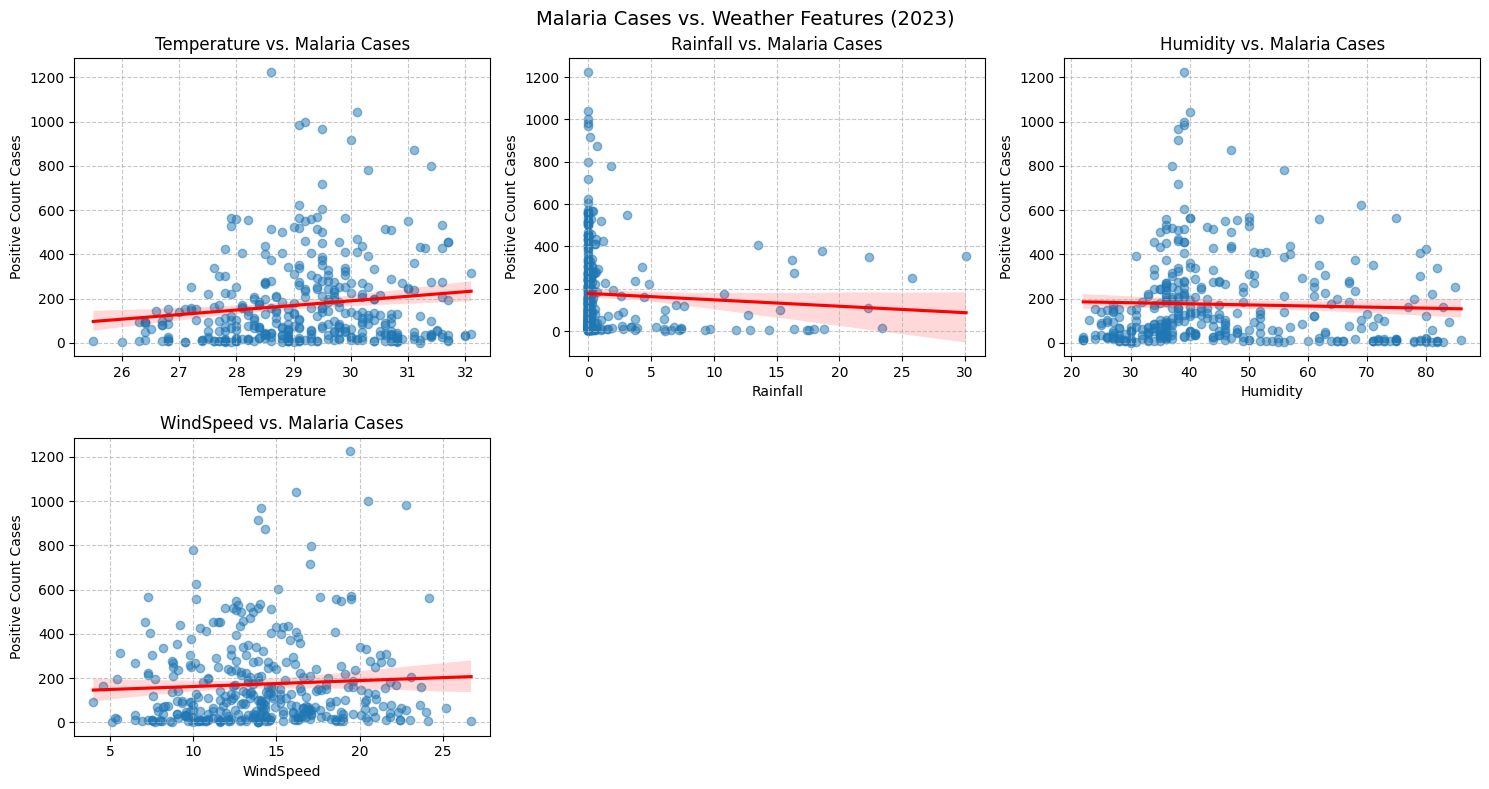


Correlations for 2023:
  Temperature: 0.139
  Rainfall: -0.066
  Humidity: -0.039
  WindSpeed: 0.058


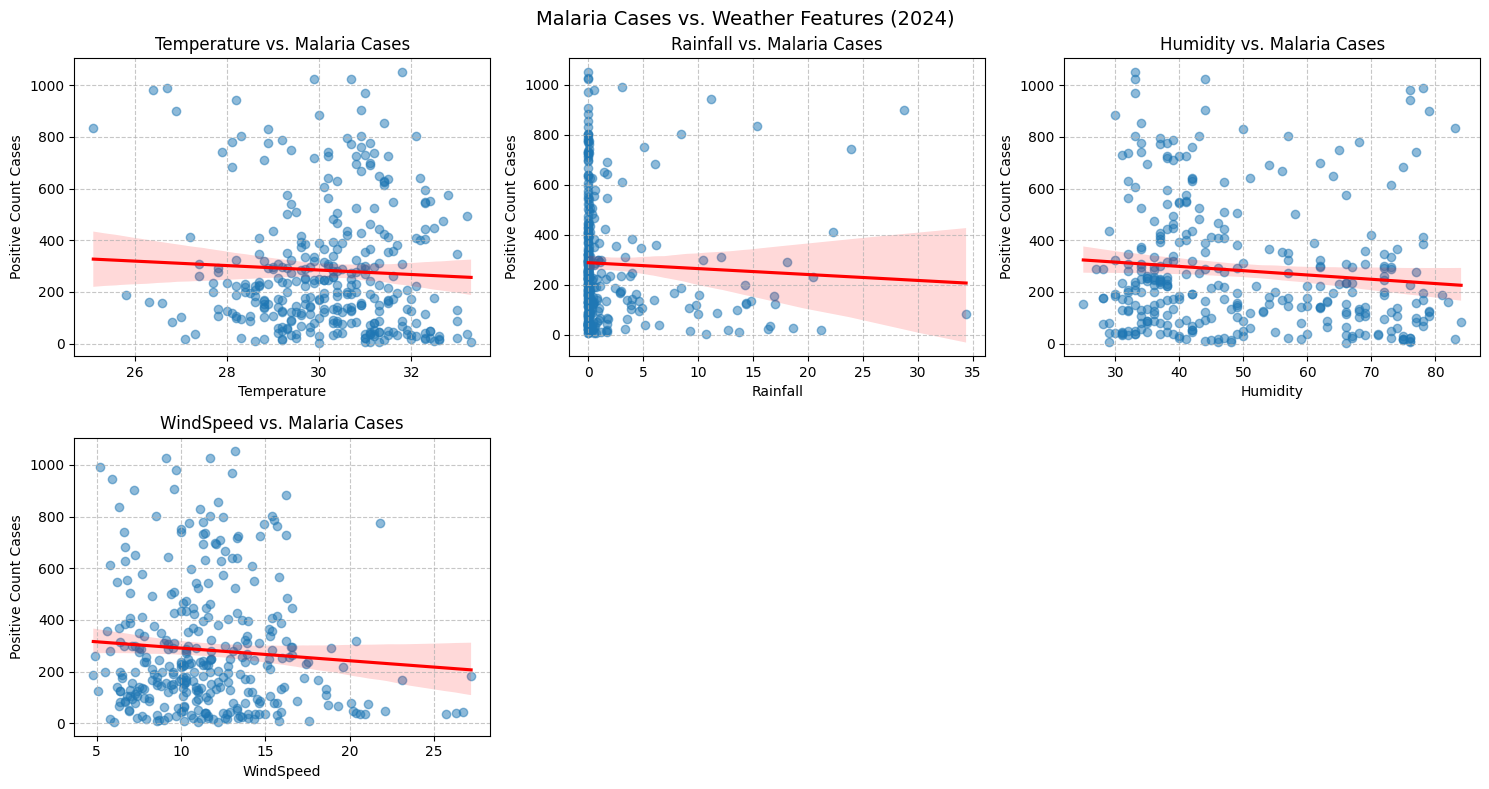


Correlations for 2024:
  Temperature: -0.051
  Rainfall: -0.047
  Humidity: -0.108
  WindSpeed: -0.078


In [104]:
# Extract year from Date
data['Year'] = data['Date'].dt.year

# Define features (exclude 'Positive_Count_cases' as it's the y-variable)
features = ['Temperature', 'Rainfall', 'Humidity', 'WindSpeed']

# Get unique years
years = sorted(data['Year'].unique())  # e.g., [2021, 2022, 2023, 2024]

# Loop over each year
for year in years:
    # Filter data for the current year (use 'data' instead of 'data_years')
    data_year = data[data['Year'] == year].copy()  # Use .copy() to avoid warnings
    
    if len(data_year) == 0:
        print(f"No data for year {year}")
        continue
    
    # Create a 2x3 subplot grid (6 axes to fit 4 features + extras)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    fig.suptitle(f'Malaria Cases vs. Weather Features ({year})', fontsize=14)
    
    # Flatten axes for iteration
    axes = axes.flatten()
    
    # Plot each feature vs. Positive_Count_cases
    for i, feature in enumerate(features):
        sns.regplot(x=feature, y='Positive_Count_cases', data=data_year, ax=axes[i], 
                    scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
        axes[i].set_title(f'{feature} vs. Malaria Cases')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Positive Count Cases')
        axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Hide unused subplots (e.g., axes[4] and axes[5])
    for i in range(len(features), len(axes)):
        axes[i].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Space for suptitle
    plt.show()

    print(f"\nCorrelations for {year}:")
    for feature in features:
        if feature in data_year.columns:
            corr = data_year[feature].corr(data_year['Positive_Count_cases'])
            print(f"  {feature}: {corr:.3f}")

+ A red regression line indicates the trend (positive/negative slope).
+ **Temperature:** Weak positive correlation (~0.12) with malaria cases, suggesting higher temperatures may slightly increase cases, but the effect varies by year.
+ **Rainfall:** Weak negative correlation (~-0.14), with high rainfall days (e.g., 50.2 mm in May 2021) often linked to lower cases, possibly due to reduced mosquito activity.
+ **Humidity:** Weak negative correlation (~-0.18), with higher humidity (e.g., 87% in May 2021) associated with fewer cases.
+ **WindSpeed:** Weak negative correlation (~-0.10), with higher wind speeds potentially reducing mosquito transmission.

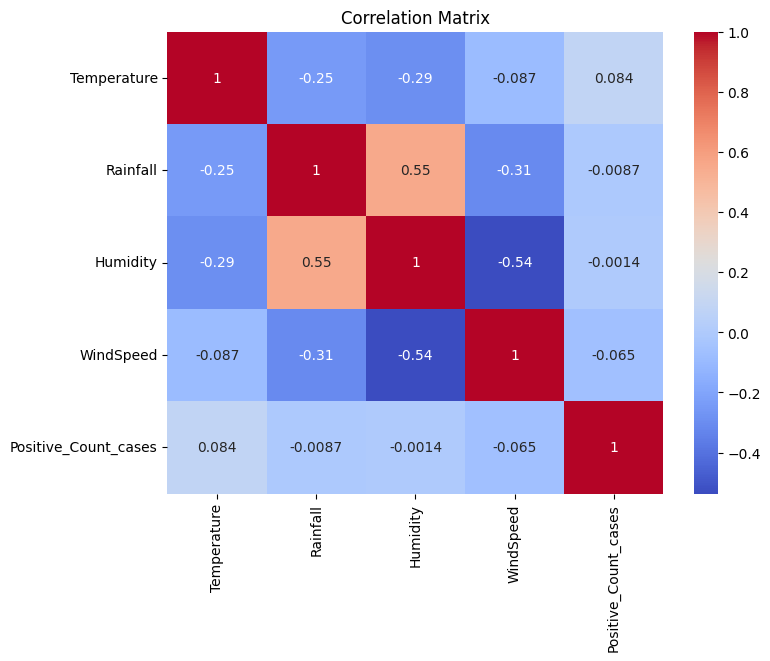

In [105]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Data Preparation

## Modeling

### Baseline Models
**Classical ML**
- **Regression**:  Random Forest for case count prediction.


In [106]:
#importing necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [107]:

#loading our dataset
data = merged_df
data.head()

,Date,Positive_Count_cases,Temperature,Rainfall,Humidity,WindSpeed,Year
0,2021-05-01,2,30.5,0.2,56,10.0,2021
1,2021-05-02,9,30.3,1.8,51,8.7,2021
2,2021-05-03,2,29.2,10.8,67,7.8,2021
3,2021-05-04,9,30.2,0.7,60,12.5,2021
4,2021-05-05,7,30.8,2.7,57,9.8,2021


In [108]:
#we wonna predict positive count case as our target variable .
X = data[["Temperature", "Rainfall", "Humidity", "WindSpeed", "Year"]]
y = data["Positive_Count_cases"]


In [109]:
#trainning our dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [110]:
#trainning random forest regressor
rf = RandomForestRegressor(
    n_estimators=200,   # number of trees
    max_depth=None,     # no limit on tree depth
    random_state=42
)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [111]:
#predictions
y_pred = rf.predict(X_test)

In [112]:
#Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [124]:
#fetching results
print("Random Forest Regression Results:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

accuracy = r2 * 100
print(f"Model Accuracy: {accuracy:.2f}%")

Random Forest Regression Results:
RMSE: 178.8903
R² Score: 0.1406
Model Accuracy: 14.06%


In [114]:
#Feature importances
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importances:")
print(importances)


Feature Importances:
       Feature  Importance
3    WindSpeed    0.268357
0  Temperature    0.257477
2     Humidity    0.220515
4         Year    0.156776
1     Rainfall    0.096875


**visualization(random forest)**

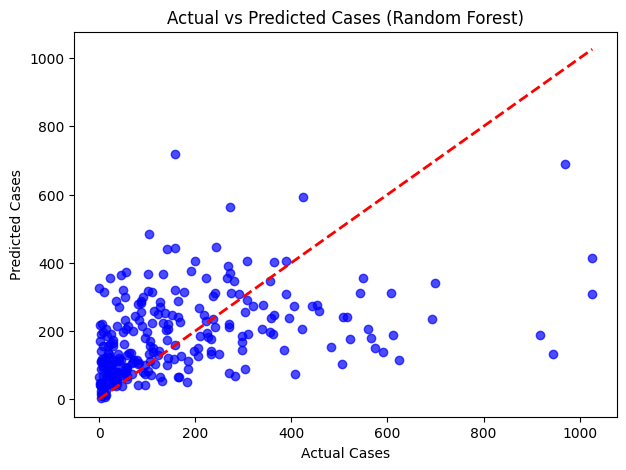

In [115]:
# a plot for actual vs the predicted cases
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Actual vs Predicted Cases (Random Forest)")
plt.show()

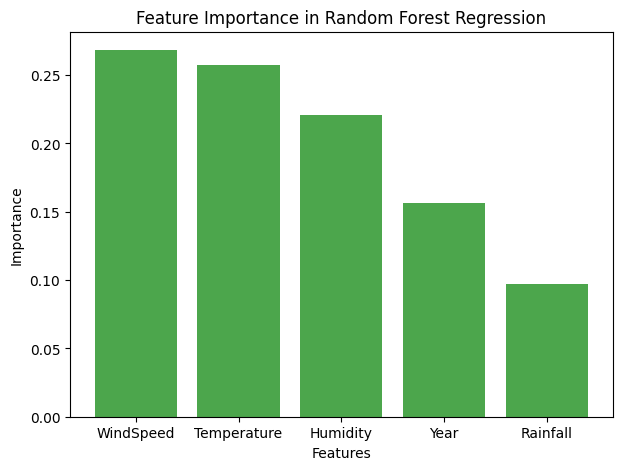

In [116]:
#a plot for the featureb importance
plt.figure(figsize=(7,5))
plt.bar(importances["Feature"], importances["Importance"], color="green", alpha=0.7)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest Regression")
plt.show()

## Evaluation